In [1]:
# This file requires this torch version for reproducibility..., in contrast to the benchmarks which use 1.13.1
!pip install torch==1.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116  --user
import torch
assert torch.__version__ == "1.13.0+cu116", "Please install torch 1.13.0 to reproduce this"

from rbi.models import InverseAffineAutoregressiveModel
from rbi.loss import NLLLoss

from rbibm.tasks import HHTask
from rbibm.tasks.hh_task import SimpleHHTask
import torch 
from torch import nn

import matplotlib.pyplot as plt

seed = 0
torch.manual_seed(seed)

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
  Using cached https://download.pytorch.org/whl/cu116/torch-1.13.0%2Bcu116-cp39-cp39-win_amd64.whl (2436.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\manug\\AppData\\Roaming\\Python\\Python39\\site-packages\\~-nctorch\\_C.cp39-win_amd64.pyd'
Check the permissions.

C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
torch.__version__

'1.13.0+cu116'

In [3]:
colors = ["#08519c", "#d94801"]

In [4]:
task = SimpleHHTask()
prior = task.get_prior()
simulator = task.get_simulator()
train_loader, _,_ = task.get_train_test_val_dataset(10000,0,0)

In [5]:
model = InverseAffineAutoregressiveModel(task.input_dim, task.output_dim, output_transform=torch.distributions.biject_to(prior.support), num_transforms=3, embedding_net=nn.Sequential(nn.Linear(500,200), nn.ReLU(),nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 50), nn.ReLU()), hidden_dims=[100,100])
loss_fn = NLLLoss(model)

In [6]:
num_epochs = 40
optim = torch.optim.Adam(model.parameters())
for i in range(num_epochs):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.)
        optim.step()
    print(l)

tensor([9.2542], grad_fn=<AddBackward0>)
tensor([8.4607], grad_fn=<AddBackward0>)
tensor([7.8071], grad_fn=<AddBackward0>)
tensor([7.7755], grad_fn=<AddBackward0>)
tensor([8.1016], grad_fn=<AddBackward0>)
tensor([6.8904], grad_fn=<AddBackward0>)
tensor([6.8233], grad_fn=<AddBackward0>)
tensor([6.0251], grad_fn=<AddBackward0>)
tensor([6.2589], grad_fn=<AddBackward0>)
tensor([6.1069], grad_fn=<AddBackward0>)
tensor([6.3163], grad_fn=<AddBackward0>)
tensor([7.6844], grad_fn=<AddBackward0>)
tensor([6.0297], grad_fn=<AddBackward0>)
tensor([5.4683], grad_fn=<AddBackward0>)
tensor([9.2171], grad_fn=<AddBackward0>)
tensor([5.7812], grad_fn=<AddBackward0>)
tensor([5.7043], grad_fn=<AddBackward0>)
tensor([5.1988], grad_fn=<AddBackward0>)
tensor([5.2126], grad_fn=<AddBackward0>)
tensor([5.7353], grad_fn=<AddBackward0>)
tensor([5.7488], grad_fn=<AddBackward0>)
tensor([4.7494], grad_fn=<AddBackward0>)
tensor([5.2045], grad_fn=<AddBackward0>)
tensor([5.3752], grad_fn=<AddBackward0>)
tensor([5.7706],

In [7]:
torch.manual_seed(seed + 1)

In [8]:
thetas = prior.sample((1000,))
xs = simulator(thetas)

In [9]:
from rbibm.metric.robustness_metric import ReverseKLRobMetric, ReverseKLLoss
from rbi.attacks import LinfPGDAdamAttack

In [10]:
attack = LinfPGDAdamAttack(model, ReverseKLLoss(mc_samples=5), eps=3., eps_iter=0.1, nb_iter=200)

In [11]:
m = ReverseKLRobMetric(model, attack)

In [12]:
m.eval(xs.contiguous())

tensor(40.4724)

In [13]:
x_idx, x_o_tilde = m.generate_adversarial_examples(xs)

In [14]:
x_o = xs[x_idx[1]].unsqueeze(0)
theta = thetas[x_idx[1]].unsqueeze(0)

In [15]:
x_o_tilde= x_o_tilde[1].unsqueeze(0)

In [38]:
linear_interpolations = torch.linspace(0, 1, 109)

interpolated_samples = torch.stack([x_o_tilde * alpha + x_o * (1 - alpha) for alpha in linear_interpolations]).squeeze(1)
qs = model(interpolated_samples)
samples_qs = qs.sample((1000,))

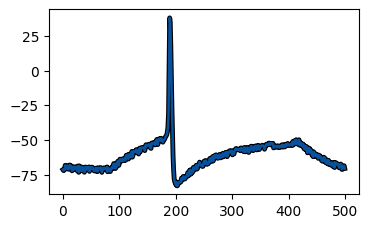

In [32]:
import matplotlib.patheffects as pe
import matplotlib 
from matplotlib.animation import FuncAnimation



fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(interpolated_samples[50].T, color=colors[0],lw=1.8,path_effects=[pe.Stroke(linewidth=3.5, foreground='black'), pe.Normal()])

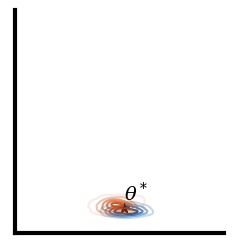

In [76]:
import matplotlib as mpl
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples_qs[:,0].squeeze(),samples_qs[:,20].squeeze()],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=colors)
   
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

In [80]:
samples_qs.shape

torch.Size([1000, 109, 2])

In [89]:
predictives = torch.stack([simulator(samples_qs[i]) for i in range(100)])

In [219]:
mean = predictives.mean(0)
q_upper = predictives.quantile(0.9, dim=0)
q_lower = predictives.quantile(0.1, dim=0)

In [149]:
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgb
y = torch.linspace(0, 100, 100)
x = torch.linspace(20,35, 100)
xx, yy = torch.meshgrid(x, y)
pos = torch.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

In [221]:
%matplotlib tk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig = plt.figure(figsize=(5,3))
    gs = GridSpec(3, 2, height_ratios=[1,1, 1])

    # Create the GridSpec
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title(r'Observation $x_o$', color=colors[0], fontsize=9)
    ax1.set_axis_off()
    _ = ax1.plot(interpolated_samples[0].T, color=colors[0],lw=1.5,)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title(r'Perturbed $x_o + \delta $', color=colors[1], fontsize=11)
    ax2.set_axis_off()
    _ = ax2.plot(interpolated_samples[0].T, color=colors[1],lw=1.5)

    ax3 = fig.add_subplot(gs[:2, 1])
    ax3.set_title('Estimated posterior')
    ax3.set_ylabel(r'$\theta_1$')
    ax3.set_xlabel(r'$\theta_2$')
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4 = fig.add_subplot(gs[-1, 1])
    ax4.set_title('Predictions')
    ax4.set_ylim(-100, 40)
    ax4.set_ylabel("Volt. [mV]")
    ax4.set_xlabel("Time [ms]")
    ax4.set_xticks([])
    ax4.set_yticks([])

    plt.tight_layout()
    
    def update(index):

        ax2.clear()
        ax3.clear()
        ax4.clear()
    
        ax2.set_title(r'Perturbed $x_o + \delta $', color=colors[1])
        ax2.set_axis_off()
        _ = ax2.plot(interpolated_samples[index].T, color=colors[1],lw=1.5)

        # Plot 3
        ax3.set_title('Inference')
        p_xy1 = gaussian_kde(samples_qs[:, 0].numpy().T)
        p_xy2 = gaussian_kde(samples_qs[:, index].numpy().T)
        f_xy1 = p_xy1(pos.numpy().T).reshape(xx.shape)
        f_xy2 = p_xy2(pos.numpy().T).reshape(xx.shape)
        ax3.set_ylabel(r'$\theta_1$')
        ax3.set_xlabel(r'$\theta_2$')
        ax3.set_xticks([])
        ax3.set_yticks([])

        cmap = ListedColormap([to_rgb(colors[0]) + (i,) for i in torch.linspace(0, 1, 10)]) # type: ignore
        ax3.contour(xx, yy, f_xy1, levels=5, cmap=cmap)
        cmap = ListedColormap([to_rgb(colors[1]) + (i,) for i in torch.linspace(0, 1, 10)]) # type: ignore
        ax3.contour(xx, yy, f_xy2, levels=5, cmap=cmap)


        ax3.scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
        ax3.text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)


        # Plot 4
        ax4.set_title('Predictions')
        t = torch.linspace(0,60, 500)
        ax4.plot(t, mean[index], color=colors[1], lw=1.5)
        ax4.fill_between(t, q_lower[index], q_upper[index], color=colors[1], alpha=0.3)
        ax4.set_ylim(-100, 40)
        ax4.set_ylabel("Volt. [mV]")
        ax4.set_xlabel("Time [ms]")
        ax4.set_xticks([])
        ax4.set_yticks([])

        l = plt.plot([],[])


        return l


    ani = FuncAnimation(fig, update, frames=range(0, 109), blit=True, cache_frame_data =True, interval=100, repeat=False)
    ani.save("fig1.gif", dpi=200)


MovieWriter ffmpeg unavailable; using Pillow instead.
